## Graphics for Membership Levels
### This can include plotting total active members, leave, temporary leave, revoked/suspended, etc

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlalchemy
import numpy as np
from datetime import datetime

In [2]:
#connect to the database instance
user = 'root'
password = 'baeldung'
host = '172.17.0.2'
port = 3306
database = 'membership'

def get_connection():
	return sqlalchemy.create_engine(
		url="mysql+pymysql://{0}:{1}@{2}:{3}/{4}".format(
			user, password, host, port, database
		)
	)

if __name__ == '__main__':

	try:
	
		# GET THE CONNECTION OBJECT (ENGINE) FOR THE DATABASE
		engine = get_connection()
		print(
			f"Connection to the {host} for user {user} created successfully.")
	except Exception as ex:
		print("Connection could not be made due to the following error: \n", ex)

Connection to the 172.17.0.2 for user root created successfully.


In [3]:
query = '''
SELECT calendar_date, 
SUM(CASE WHEN activity_calc IN ('winback','initial enrollment','technical activation','technical reactivation','technical re-activation') THEN 1 ELSE 0 END) AS active_cnts, 
SUM(CASE WHEN activity_calc IN ('parental leave','medical leave','care giving leave') THEN 1 ELSE 0 END) AS temporary_inactivte, 
SUM(CASE WHEN activity_calc IN ('cancelled','deactivated','deactive','suspended') THEN 1 ELSE 0 END) revoked,
SUM(CASE WHEN activity_calc IN ('general leave') THEN 1 ELSE 0 END) general_leave, 
SUM(CASE WHEN activity_calc IN ('winback') THEN 1 ELSE 0 END) winbacks
FROM stack_job2 sj
INNER JOIN calendar cal ON calendar_date between start_dt AND lead_date 
GROUP BY 1 
ORDER BY 1 desc
'''
from sqlalchemy import text

with engine.connect() as conn:
    df = pd.read_sql(query, con = conn)


In [4]:
df = df.assign(calendar_date = pd.to_datetime(df['calendar_date']))

In [5]:
#describe will tell me the high watermark for members
df.describe()

,calendar_date,active_cnts,temporary_inactivte,revoked,general_leave,winbacks
count,1665,1665.000000,1665.00000,1665.000000,1665.000000,1665.000000
mean,2022-04-12 00:00:00,299.906306,8.49970,285.691892,176.193393,34.243243
min,2020-01-01 00:00:00,265.000000,3.00000,92.000000,47.000000,18.000000
25%,2021-02-20 00:00:00,283.000000,7.00000,184.000000,130.000000,31.000000
50%,2022-04-12 00:00:00,300.000000,8.00000,280.000000,181.000000,34.000000
75%,2023-06-02 00:00:00,313.000000,10.00000,388.000000,238.000000,38.000000
max,2024-07-22 00:00:00,342.000000,15.00000,469.000000,277.000000,50.000000
std,NaN,19.511544,2.27368,112.258086,63.121057,6.831351


In [6]:
#subtract winbacks from active_cnts in order to plot the regions on the stacked bar chart
df=df.assign(active_non_win = df['active_cnts'] - df['winbacks'])

In [7]:
#weekly snapshots is sufficient (intervals set to 7)
df2 = df.sort_values('calendar_date').iloc[::7]

In [17]:
#pull stats on the last measurement date
print(df.iloc[0].to_dict())
print(df.iloc[7].to_dict())
print(df.iloc[16].to_dict())
print(df.iloc[26].to_dict())
print(df.iloc[36].to_dict())
print(df.iloc[45].to_dict())
print(df.iloc[52].to_dict())

{'calendar_date': Timestamp('2024-07-22 00:00:00'), 'active_cnts': 308.0, 'temporary_inactivte': 15.0, 'revoked': 469.0, 'general_leave': 277.0, 'winbacks': 36.0, 'active_non_win': 272.0}
{'calendar_date': Timestamp('2024-07-15 00:00:00'), 'active_cnts': 311.0, 'temporary_inactivte': 14.0, 'revoked': 467.0, 'general_leave': 273.0, 'winbacks': 38.0, 'active_non_win': 273.0}
{'calendar_date': Timestamp('2024-07-06 00:00:00'), 'active_cnts': 310.0, 'temporary_inactivte': 14.0, 'revoked': 465.0, 'general_leave': 273.0, 'winbacks': 38.0, 'active_non_win': 272.0}
{'calendar_date': Timestamp('2024-06-26 00:00:00'), 'active_cnts': 308.0, 'temporary_inactivte': 14.0, 'revoked': 465.0, 'general_leave': 273.0, 'winbacks': 37.0, 'active_non_win': 271.0}
{'calendar_date': Timestamp('2024-06-16 00:00:00'), 'active_cnts': 312.0, 'temporary_inactivte': 13.0, 'revoked': 459.0, 'general_leave': 270.0, 'winbacks': 38.0, 'active_non_win': 274.0}
{'calendar_date': Timestamp('2024-06-07 00:00:00'), 'active_

In [9]:
from datetime import timedelta
datetime.strftime(graph_values['calendar_date'] - timedelta(days = 15),format='%Y-%m-%d')

'2024-07-07'

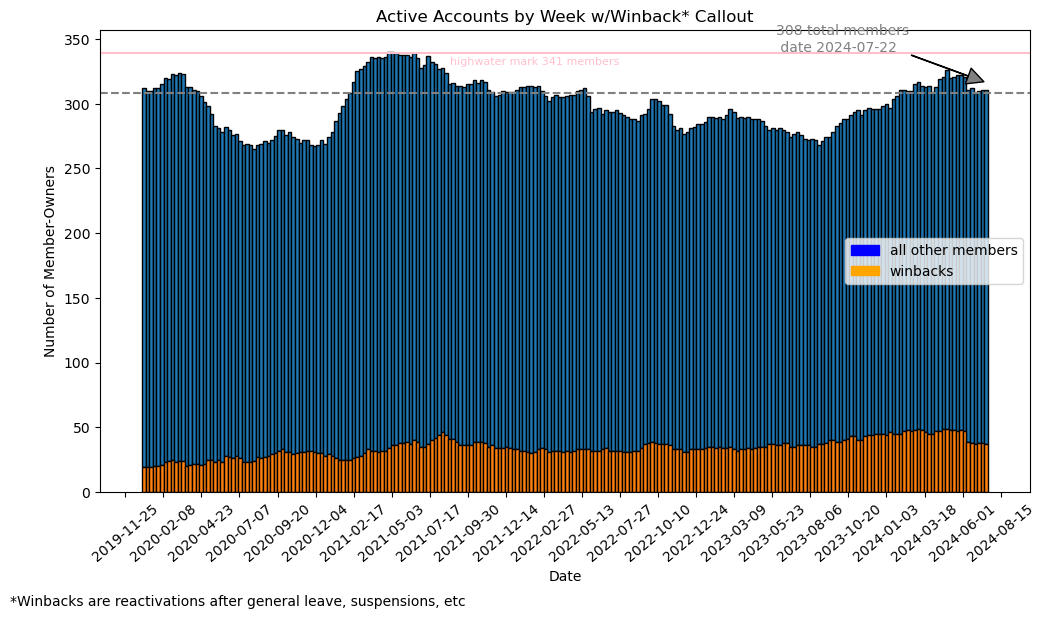

In [10]:
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker 

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(df2['calendar_date'],df2['active_non_win'],bottom=df2['winbacks'], width=7, edgecolor = 'black')
ax.bar(df2['calendar_date'],df2['winbacks'], width=7, edgecolor = 'black')
ax.set_title("Active Accounts by Week w/Winback* Callout")
ax.tick_params(axis='x', labelrotation = 40)
ax.axhline(y=339,linestyle = '-', color = 'pink')
ax.axhline(y=graph_values['active_cnts'],linestyle = '--', color = 'grey')
ax.set_ylabel('Number of Member-Owners')
ax.legend(['winbacks', 'all other members'])
#create 'artists' for the legend
blue_patch = mpatches.Patch(color='blue', label='all other members')
orange_patch = mpatches.Patch(color='orange', label='winbacks')
ax.legend(handles=[blue_patch,orange_patch], loc = 'center right')
ax.set_xlabel("Date")
ax.text(datetime(2021,8,25),330,'highwater mark 341 members',fontsize=8,color='pink')

ax.annotate(f'{int(graph_values['active_cnts'])} total members\n date {datetime.strftime(graph_values['calendar_date'],'%Y-%m-%d')}', xy=(graph_values['calendar_date'] - timedelta(days = 9), graph_values['active_cnts']+9), xycoords='data',
            xytext=(-150, 22), color='grey',textcoords='offset points',arrowprops=dict(facecolor='grey',width=0.25))
space = 75
ax.xaxis.set_major_locator(ticker.MultipleLocator(space)) 

#centering xtick labels (middle of text to coincide w/tick)
for label in ax.get_xticklabels(which='major'):
    label.set(horizontalalignment='center')

plt.figtext(0.05,-.08,'*Winbacks are reactivations after general leave, suspensions, etc')

plt.show()
